skąd są modele:
1. 
2. drugi model z pomocą czata gpt (fuzja pomiędzy klasycznym LSTM i transformerem)

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from NN_data_prep import set_seed, plot_time_series, preprocess_series, prepare_dataset
from NN_models import LSTMForecaster, LSTMAttentionForecaster

In [13]:
param = 'puls'

df_aug = pd.read_csv('data/df_augmented_' + param + '.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_aug.set_index('date', inplace=True)
series_aug = df_aug['aug_series_00001']

df_original = pd.read_csv('data/df_stl_interpolated.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_original.set_index('date', inplace=True)
series_original = df_original[param]

In [14]:
print(series_aug.head(2))
print(series_original.head(2))

date
2023-11-13 14:00:00    136
2023-11-13 15:00:00    128
Name: aug_series_00001, dtype: int64
date
2023-11-13 14:00:00    125
2023-11-13 15:00:00    130
Name: puls, dtype: int64


In [15]:
series_original.head(3)

date
2023-11-13 14:00:00    125
2023-11-13 15:00:00    130
2023-11-13 16:00:00    145
Name: puls, dtype: int64

### 2 NN models definitions:

description:
##### I. LSTMForecaster:
*init* -\
*forward* -
##### II. LSTMAttentionForecaster:
*init* -\
*forward* -

Generate data and plot them:

In [78]:
# localise anomalies with Ciotka's help
set_seed(42)
x, y = preprocess_series(series_original)
anomalies = [49, 61, 69, 91, 94, 175, 231, 347]

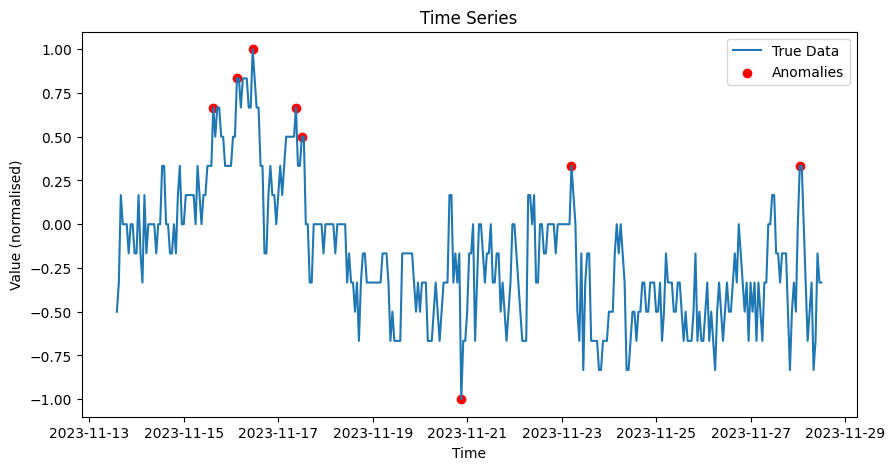

In [79]:
plot_time_series(x, y, anomalies)
plt.show()

Create dataset to feed into the model:

In [18]:
seq_len = 3
X, Y = prepare_dataset(y, seq_len)

Train model on prepared dataset:

In [19]:
# Train a chosen model
# model = LSTMForecaster()
model = LSTMAttentionForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
training_series_length = 100

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X[0:training_series_length])
    if type(model) == LSTMForecaster:
        loss = criterion(pred[:, -1, :], Y[0:training_series_length])
    elif type(model) == LSTMAttentionForecaster:
        loss = criterion(pred, Y[0:training_series_length])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.14350736141204834
Epoch 10, Loss: 0.049314357340335846
Epoch 20, Loss: 0.04699135199189186
Epoch 30, Loss: 0.03957061842083931
Epoch 40, Loss: 0.03164272755384445
Epoch 50, Loss: 0.031715814024209976
Epoch 60, Loss: 0.028770513832569122
Epoch 70, Loss: 0.028512798249721527
Epoch 80, Loss: 0.027069173753261566
Epoch 90, Loss: 0.02486296370625496


Predict values using trained model:

In [20]:
model.eval()
with torch.no_grad():
    if type(model) == LSTMForecaster:
        pred = model(X).numpy().squeeze()[:, -1]
    elif type(model) == LSTMAttentionForecaster:
        pred = model(X).numpy().squeeze()

Anomaly detection:

In [21]:
# residuals = np.abs(Y.numpy().squeeze() - pred[:, -1])
residuals = np.abs(Y.numpy().squeeze() - pred.squeeze())
threshold = np.mean(residuals) + 2 * np.std(residuals)
detected_anomalies = np.where(residuals > threshold)[0] + seq_len

Results visualisation:

<class 'NN_models.LSTMAttentionForecaster'>


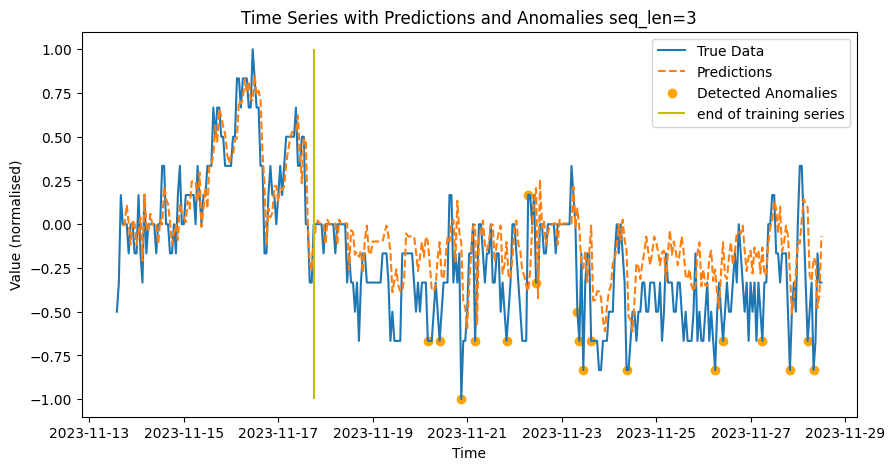

In [22]:
print(type(model))
plot_time_series(x, y, anomalies, pred, title=f"Time Series with Predictions and Anomalies seq_len={seq_len}")
plt.scatter(x[detected_anomalies], y[detected_anomalies], color='orange', label="Detected Anomalies")
plt.vlines(x[training_series_length], -1, 1, color='y', label='end of training series')
plt.legend()
plt.show()